<a href="https://colab.research.google.com/github/bgoueti/Data-Science-BloomTech/blob/main/LS_DS_222_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BloomTech Data Science

*Unit 2, Sprint 2, Module 2*

---

# Module Project: Random Forests

This week, the module projects will focus on creating and improving a model for the Tanazania Water Pump dataset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or functional needs repair.

## Directions

The tasks for this project are as follows:

- **Task 1:** Sign up for a [Kaggle](https://www.kaggle.com/) account. Join the kaggle competition, and download the water pump dataset.
- **Task 2:** Modify `wrangle` function to engineer a new feature. Use `wrangle` function to import training and test data.
- **Task 3:** Split training data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and validation sets.
- **Task 5:** Establish the baseline accuracy score for your dataset.
- **Task 6:** Build and train `model_rf`.
- **Task 7:** Calculate the training and validation accuracy score for your model.
- **Task 8:** Adjust model's `max_depth` and `n_estimators` to reduce overfitting.
- **Task 9:** Generate list of predictions for `X_test`.
- **Task 9 `stretch goal`:** Create `submissions.csv` file and upload on kaggle competition site.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `ydata-profiling`
- `sklearn`

# I. Wrangle Data

In [73]:
# Installing packages

%%capture
!pip install category_encoders==2.*
!pip install pandas_profiling==2.*
!pip install ydata-profiling==2.*

In [74]:
# Import Libraries

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
#from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [75]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path,
                                  na_values=[0, -2.000000e-08],
                                  parse_dates = ['date_recorded']),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path,
                         na_values=[0, -2.000000e-08],
                         parse_dates = ['date_recorded'],
                         index_col='id')

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Create the engineering 'pump_age' feature
    df['pump_age'] = pd.to_datetime(df['date_recorded']).dt.year - df['construction_year']
    df.drop(columns = 'date_recorded', inplace = True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(100).T.duplicated().index
                 if df.head(100).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)

    return df

**Task 1:** Sign up for a [Kaggle](https://www.kaggle.com/) account. Choose a username that's based on your real name. Like GitHub, Kaggle is part of your public profile as a data scientist.

**Task 2:** Modify the `wrangle` function to engineer a `'pump_age'` feature. Then use the function to read `train_features.csv` and `train_labels.csv` into the DataFrame `df`, and `test_features.csv` into the DataFrame `X_test`.

In [76]:
train_features = '/content/train_features.csv'
train_labels = '/content/train_labels.csv'
test_features = '/content/test_features.csv'

In [77]:
df = wrangle(train_features, train_labels)
X_test = wrangle(test_features)

In [78]:
df.shape, X_test.shape

((59399, 31), (14358, 30))

In [79]:
df.head()

,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,...,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,pump_age
id,,,,,,,,,,,,,,,,,,,,,
69572.0,6000.0,1390.0,34.938093,-9.856322,NaN,Lake Nyasa,Iringa,11,5.0,109.0,...,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,12.0
8776.0,NaN,1399.0,34.698766,-2.147466,NaN,Lake Victoria,Mara,20,2.0,280.0,...,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,3.0
34310.0,25.0,686.0,37.460664,-3.821329,NaN,Pangani,Manyara,21,4.0,250.0,...,soft,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,4.0
67743.0,NaN,263.0,38.486161,-11.155298,NaN,Ruvuma / Southern Coast,Mtwara,90,63.0,58.0,...,soft,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,27.0
19728.0,NaN,NaN,31.130847,-1.825359,NaN,Lake Victoria,Kagera,18,1.0,NaN,...,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,NaN


In [80]:
#df.info()

# II. Split Data

**Task 3:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

In [81]:
target = 'status_group'

X = df.drop(columns = target)
y = df[target]

**Task 4:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [82]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.2, random_state = 42)


In [83]:
X_train.shape, y_train.shape

((11879, 30), (11879,))

In [84]:
X_val.shape, y_val.shape

((47520, 30), (47520,))

# III. Establish Baseline

**Task 5:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [85]:
y_train.value_counts(normalize = True)

functional                 0.544154
non functional             0.385386
functional needs repair    0.070460
Name: status_group, dtype: float64

In [86]:
baseline_acc = y_train.value_counts(normalize = True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5441535482784746


# IV. Build Model

**Task 6:** Build a `Pipeline` named `model_rf`, and fit it to your training data. Your `Pipeline` should include:

- an `OrdinalEncoder` transformer for categorical features.
- a `SimpleImputer` transformer fot missing values.
- a `RandomForestClassifier` predictor.

**Note:** Don't forget to set the `random_state` parameter for your `RandomForestClassifier`. Also, to decrease training time, set `n_jobs` to `-1`.

In [87]:
model_rf = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(),
                         RandomForestClassifier(n_jobs = -1))
model_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoin...
                                          'mapping': communal standpipe             1
communal standpipe multiple    2
improved spring                3
other                          4
hand pump                      5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                                         {'col': 'waterpoint_type_group',
                                          'data_type': dtype('O'),
                                          'mapping': communal standpipe    1
improved spring       2
other                 3
hand pump             4
cattle trough         5
dam                   6
NaN                  -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier', RandomForestClassifier(n_jobs=-1))])

# V. Check Metrics

**Task 7:** Calculate the training and validation accuracy scores for `model_rf`.

In [88]:
training_acc = model_rf.score(X_train, y_train)
val_acc = model_rf.score(X_val, y_val)

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.9963801666806971
Validation Accuracy Score: 0.77243265993266


# VI. Tune Model

**Task 8:** Tune `n_estimators` and `max_depth` hyperparameters for your `RandomForestClassifier` to get the best validation accuracy score for `model_rf`.

In [89]:
# Use this cell to experiment and then change
# your model hyperparameters in Task 6

train_acc = []
val_acc = []

depths = np.arange(9, 15, 1)

for depth in depths:
  model_rf = make_pipeline(OrdinalEncoder(),
                           SimpleImputer(),
                           RandomForestClassifier(max_depth = depth,
                                                  n_estimators = 40, n_jobs= -1))

  model_rf.fit(X_train, y_train)

  train_acc.append(model_rf.score(X_train, y_train))
  val_acc.append(model_rf.score(X_val, y_val))

  print('Training Accuracy Score:', train_acc)
  print('Validation Accuracy Score:', val_acc)


Training Accuracy Score: [0.7805370822459803]
Validation Accuracy Score: [0.7401515151515151]
Training Accuracy Score: [0.7805370822459803, 0.7972051519488172]
Validation Accuracy Score: [0.7401515151515151, 0.7448442760942761]
Training Accuracy Score: [0.7805370822459803, 0.7972051519488172, 0.8169879619496591]
Validation Accuracy Score: [0.7401515151515151, 0.7448442760942761, 0.7504419191919192]
Training Accuracy Score: [0.7805370822459803, 0.7972051519488172, 0.8169879619496591, 0.8366865897802845]
Validation Accuracy Score: [0.7401515151515151, 0.7448442760942761, 0.7504419191919192, 0.7573653198653199]
Training Accuracy Score: [0.7805370822459803, 0.7972051519488172, 0.8169879619496591, 0.8366865897802845, 0.8580688610152369]
Validation Accuracy Score: [0.7401515151515151, 0.7448442760942761, 0.7504419191919192, 0.7573653198653199, 0.7615951178451178]
Training Accuracy Score: [0.7805370822459803, 0.7972051519488172, 0.8169879619496591, 0.8366865897802845, 0.8580688610152369, 0.88

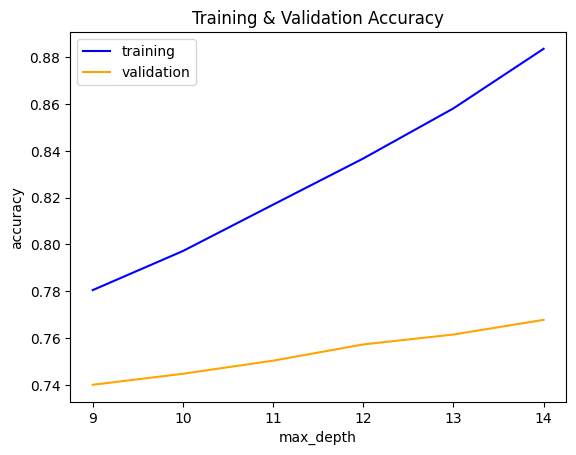

In [90]:
plt.plot(depths, train_acc, color = 'blue', label = 'training')
plt.plot(depths, val_acc, color = 'orange', label = 'validation')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.show()

# VII. Communicate Results

**Task 9:** Generate a list of predictions for `X_test`. The list should be named `y_pred`.

In [91]:
y_pred = model_rf.predict(X_test)

assert len(y_pred) == len(X_test), f'Your list of predictions should have {len(X_test)} items in it.'


In [92]:
y_pred

array(['functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

**Task 11 `stretch goal`:** Create a DataFrame `submission` whose index is the same as `X_test` and that has one column `'status_group'` with your predictions. Next, save this DataFrame as a CSV file and upload your submissions to our competition site.

**Note:** Check the `sample_submission.csv` file on the competition website to make sure your submissions follows the same formatting.

In [93]:
submission = pd.DataFrame(data = model_rf.predict(X_test), index = X_test.index)

submission


,0
id,
50785,functional
51630,functional
17168,functional
45559,non functional
49871,functional
...,...
39307,non functional
18990,functional
28749,functional
